In [1]:
## processing
import numpy as np
import pandas as pd

## custom package
import tregs

## visualization
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
plt.rcParams.update({'font.size': 12})
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = "Arial"

## Loading sequencing data

In [2]:
fpath = '../../data/ykgE_dataset_combined.csv'
df_ykgE = pd.read_csv(fpath)

def trim_seqs(row):
    return row['seq'][:160]

df_ykgE['seq'] = df_ykgE.apply(trim_seqs, axis=1)
df_ykgE = df_ykgE[df_ykgE.ct_0 != 0.0]
df_ykgE['norm_ct_1'] = (df_ykgE['ct_1'] + 1) / df_ykgE['ct_0']

n_seqs = len(df_ykgE)

## Information footprint: Minimum binning

### 1. Representing mutations as probability distribution

In [3]:
wtseq = 'TCGATTTCCCCATAAAATGTGAGCGATGCCGAAAGAAATAAAATTAGTTATTGCATTTGACGTTTGGATGAAAGATTATCATTTGTCATACAAATGAGGGGTGGTATGTTGCTAGCCAATTAAAAAAGAACGCCATATTTATTGATGATTGATCCCCCGG'

In [4]:
wtlist = np.array(list(wtseq))
wt_arr = np.vstack([wtlist] * n_seqs)

In [5]:
mut_list = df_ykgE['seq'].values
mut_arr = np.asarray([list(mutant) for mutant in mut_list.tolist()])

In [6]:
all_mutarr = wt_arr != mut_arr
all_mutarr

array([[ True, False,  True, ..., False, False, False],
       [ True, False, False, ..., False, False, False],
       [ True, False, False, ..., False, False, False],
       ...,
       [False,  True, False, ...,  True, False, False],
       [False,  True, False, ...,  True, False, False],
       [False,  True, False, ...,  True, False, False]])

In [7]:
list_p_b = tregs.footprint.get_p_b(all_mutarr, n_seqs)
list_p_b.shape

(160, 2)

### 2. Representing expression levels as probability distributions

In [8]:
mu_data = df_ykgE['norm_ct_1']

nbins = 4
upper_bound = 10
mu_bins, bin_cnt = tregs.footprint.bin_expression_levels(mu_data, nbins, upper_bound)
p_mu = tregs.footprint.get_p_mu(bin_cnt, n_seqs)
p_mu

array([0.89092664, 0.08011583, 0.02123552, 0.00772201])

### 3. Calculating the joint probability distribution

In [9]:
mu_bins = np.asarray(mu_bins)
mu_bins

array([0, 0, 0, ..., 0, 0, 0])

In [26]:
len_promoter = 160

list_joint_p = []
for position in range(len_promoter):
    mu_bins_tmp = mu_bins[:, np.newaxis]
    joint_p = np.zeros((2, nbins))
    for b in range(2):
        for mu in range(nbins):
            joint_p[b, mu] = np.sum(((all_mutarr == b) * (mu_bins_tmp == mu))[:, position])
    list_joint_p.append(joint_p / np.sum(joint_p))
    #list_joint_p.append(joint_p)

In [41]:
len_promoter = 160

mu_bins_tmp = mu_bins[:, np.newaxis]
list_joint_p2 = np.zeros((len_promoter, 2, nbins))
for b in range(2):
    for mu in range(nbins):
        list_joint_p2[:, b, mu] = np.sum(((all_mutarr == b) * (mu_bins_tmp == mu)), axis=0)
list_joint_p2 = list_joint_p2 / np.sum(list_joint_p2, axis=(1, 2))[:, np.newaxis, np.newaxis]

In [43]:
np.sum(np.asarray(list_joint_p) - np.asarray(list_joint_p2) > 10**(-6))

0

### 4. Calculate mutual information at each position

Finally, we can calculate the information footprint by computing the mutual information at each position given the probability distributions that we have calculated above.

In [ ]:
mutual_info = []
for position in range(len_promoter):
    p_b = list_p_b[position]
    joint_p = list_joint_p[position]

    mi = 0
    for i in range(len(p_mu)):
        mi += joint_p[0][i] * np.log2(joint_p[0][i] / (p_b[0] * p_mu[i]))
        mi += joint_p[1][i] * np.log2(joint_p[1][i] / (p_b[1] * p_mu[i]))

    mutual_info.append(mi)

In [16]:
footprint = tregs.footprint.MI(list_p_b, p_mu, list_joint_p)

### 5. Making information footprint

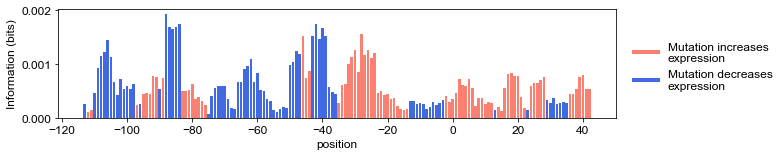

In [18]:
fig, ax = plt.subplots(figsize=(10,2))
ax.set_ylabel('Information (bits)')
ax.set_xlabel('position')

windowsize = 5
exshift_list = tregs.footprint.get_expression_shift(mut_list, mu_data.values, wtseq, smoothed=True, windowsize=windowsize)
shiftcolors = [('salmon' if exshift > 0 else 'royalblue') for exshift in exshift_list]

cut = int((windowsize - 1) / 2)
x = np.arange(-115 + cut, 45 - cut)
footprint_smoothed = tregs.utils.smoothing(footprint, windowsize=windowsize)
ax.bar(x, footprint_smoothed, edgecolor=None, color=shiftcolors)

custom_lines = [Line2D([0], [0], color='salmon', lw=4),
                Line2D([0], [0], color='royalblue', lw=4)]
ax.legend(custom_lines, ['Mutation increases\nexpression', 'Mutation decreases\nexpression'],
          bbox_to_anchor=(1.3, 0.8), frameon=False)

plt.savefig('../figs/ykgE_footprint_expression_bins.png', dpi=300, bbox_inches='tight')
plt.show()